In [2]:
!pip install wbgapi

import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Economies: PER (Peru), UMC (Upper Middle Income), WLD (World)
country_codes = ['PER', 'UMC', 'WLD']

indicators = {
    'NY.GDP.PCAP.KD': 'GDP_Per_Capita_Const',     # Standard of Living
    'SL.TLF.CACT.ZS': 'Labor_Part_Rate',          # Labor Supply
    'SL.UEM.TOTL.ZS': 'Unemployment_Rate',        # Labor Friction
    'SL.TLF.TOTL.IN': 'Labor_Force_Total',        # Total Workers
    'NY.GDP.MKTP.KD': 'GDP_Const',                # Economic Size
    'FP.CPI.TOTL.ZG': 'Inflation_CPI',            # Stability
    'NY.GDS.TOTL.ZS': 'Gross_Dom_Savings',        # Savings
    'NE.GDI.TOTL.ZS': 'Gross_Cap_Formation',      # Investment
    'NE.EXP.GNFS.ZS': 'Exports_GDP',              # Exports
    'NE.IMP.GNFS.ZS': 'Imports_GDP',              # Imports
    'GC.TAX.TOTL.GD.ZS': 'Tax_Rev_GDP',            # Gov Revenue
    'NE.CON.GOVT.ZS': 'Gov_Exp_GDP'                # Gov Spending
}

In [3]:
# 1. Fetch Data
print("Fetching data...")
df_raw = wb.data.DataFrame(indicators, economy=country_codes, time=range(2000, 2025))

# 2. Transpose (Flip Rows/Cols)
df = df_raw.T

# 3. Clean Index
df.index = df.index.str.replace('YR', '').astype(int)
df.index.name = 'Year'
df = df.sort_index()

# 4. Rename Columns
df.rename(columns=indicators, level=1, inplace=True)

# 5. Extract Peru for specific calculations
df_per = df.xs('PER', axis=1, level=0).copy()

Fetching data...


In [4]:
df_per.head()

series,Inflation_CPI,Tax_Rev_GDP,Gov_Exp_GDP,Exports_GDP,Gross_Cap_Formation,Imports_GDP,GDP_Const,GDP_Per_Capita_Const,Gross_Dom_Savings,Labor_Part_Rate,Labor_Force_Total,Unemployment_Rate
Year,,,,,,,,,,,,
2000,3.757338,12.608647,11.450627,16.768374,19.627985,18.769658,8.740938e+10,3286.273085,17.626700,65.780,11421931.0,4.958
2001,1.977099,12.897106,11.717171,16.601380,18.159505,18.463022,8.794948e+10,3261.664251,16.297863,68.790,12219945.0,5.063
2002,0.193135,12.487143,11.165026,17.274808,17.968146,17.974373,9.274583e+10,3398.749914,17.268580,69.905,12684641.0,4.840
2003,2.259378,13.411521,11.518717,19.014667,17.510289,18.609943,9.660871e+10,3502.791657,17.915013,70.997,13141062.0,4.150
2004,3.662473,13.663369,11.256279,22.912234,16.855683,19.023845,1.013988e+11,3640.602999,20.744072,72.065,13588521.0,4.710


In [5]:
# 1. Natural Rate of Unemployment (5-Year MA)
df_per['Natural_Rate_Unemp'] = df_per['Unemployment_Rate'].rolling(window=5).mean()

# 2. Productivity (Output per Worker)
df_per['Productivity'] = df_per['GDP_Const'] / df_per['Labor_Force_Total']

# 3. Net Capital Outflow (Exports - Imports)
df_per['NCO'] = df_per['Exports_GDP'] - df_per['Imports_GDP']

# 4. Budget Balance (Tax - Spending)
df_per['Budget_Balance'] = df_per['Tax_Rev_GDP'] - df_per['Gov_Exp_GDP']

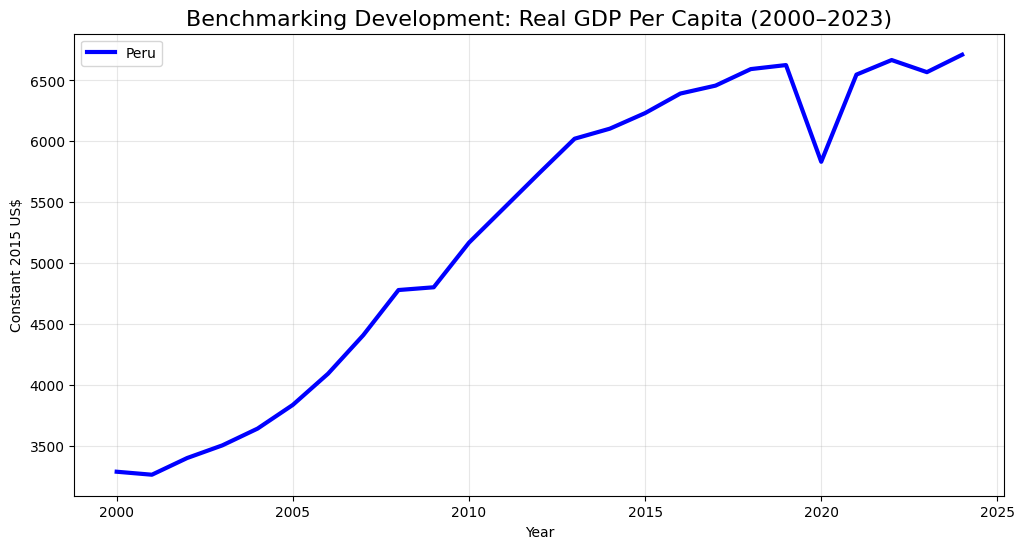

In [7]:
plt.figure(figsize=(12, 6))

# Plot ONLY Peru
plt.plot(
    df.index,
    df[('PER', 'GDP_Per_Capita_Const')],
    label='Peru',
    color='blue',
    linewidth=3
)

plt.title('Benchmarking Development: Real GDP Per Capita (2000–2023)', fontsize=16)
plt.ylabel('Constant 2015 US$')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

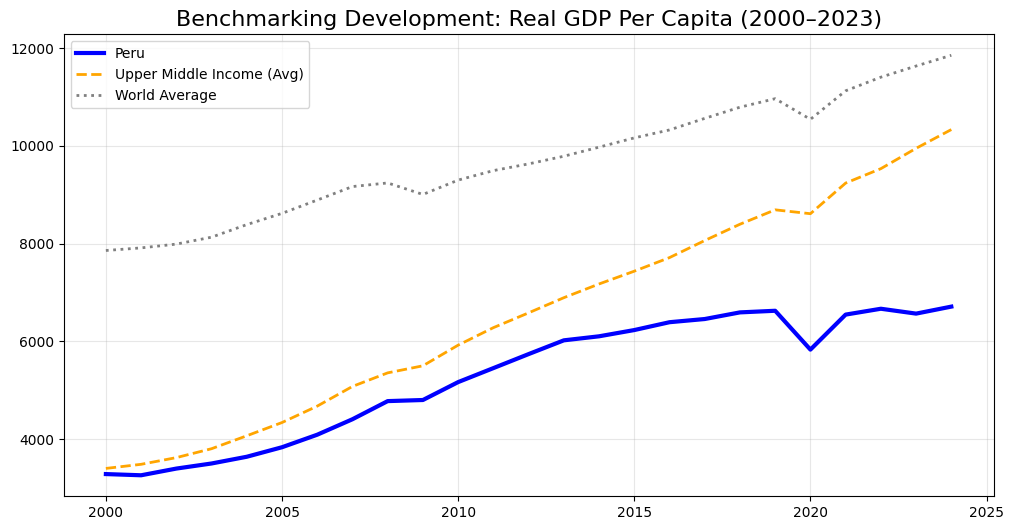

In [8]:
plt.figure(figsize=(12, 6))

# Peru
plt.plot(
    df.index,
    df[('PER', 'GDP_Per_Capita_Const')],
    label='Peru',
    color='blue',
    linewidth=3
)

# Upper Middle Income (Average)
plt.plot(
    df.index,
    df[('UMC', 'GDP_Per_Capita_Const')],
    label='Upper Middle Income (Avg)',
    color='orange',
    linestyle='--',
    linewidth=2
)

# World Average
plt.plot(
    df.index,
    df[('WLD', 'GDP_Per_Capita_Const')],
    label='World Average',
    color='grey',
    linestyle=':',
    linewidth=2
)

plt.title('Benchmarking Development: Real GDP Per Capita (2000–2023)', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

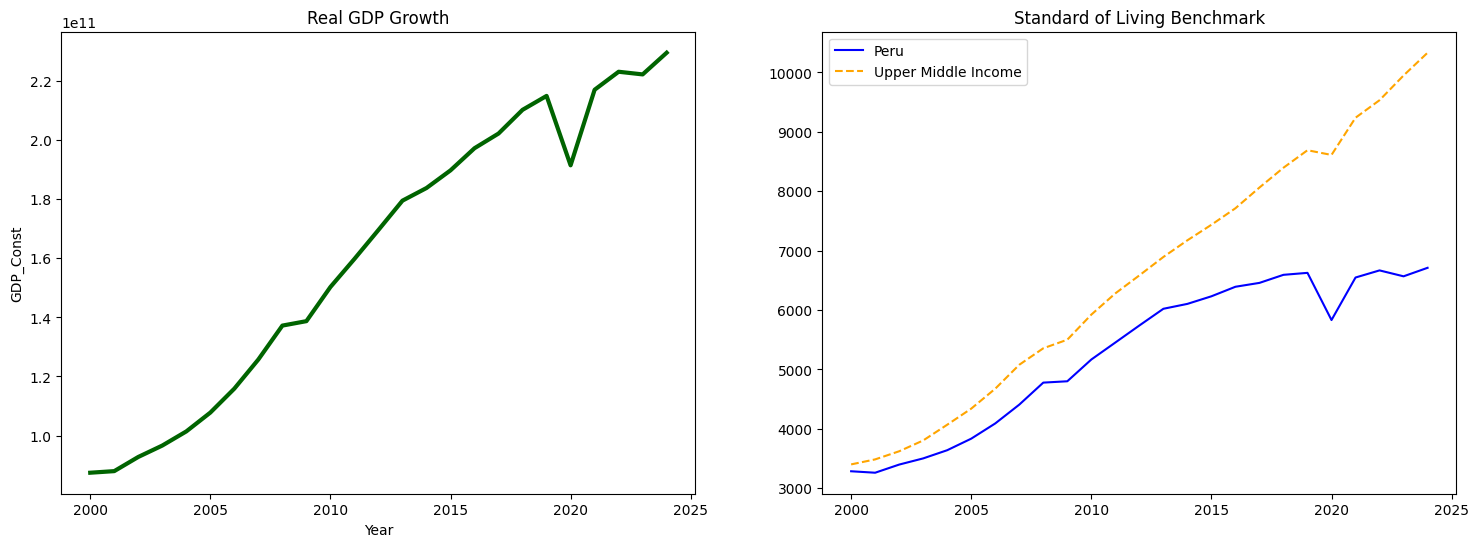

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Chart A: Total GDP (Peru)
sns.lineplot(
    data=df_per,
    x=df_per.index,
    y='GDP_Const',
    color='darkgreen',
    linewidth=3,
    ax=ax1
)
ax1.set_title('Real GDP Growth')

# Chart B: GDP Per Capita Benchmark
ax2.plot(df.index, df[('PER', 'GDP_Per_Capita_Const')], color='blue', label='Peru')
ax2.plot(df.index, df[('UMC', 'GDP_Per_Capita_Const')], color='orange', linestyle='--', label='Upper Middle Income')
ax2.set_title('Standard of Living Benchmark')
ax2.legend()

plt.show()

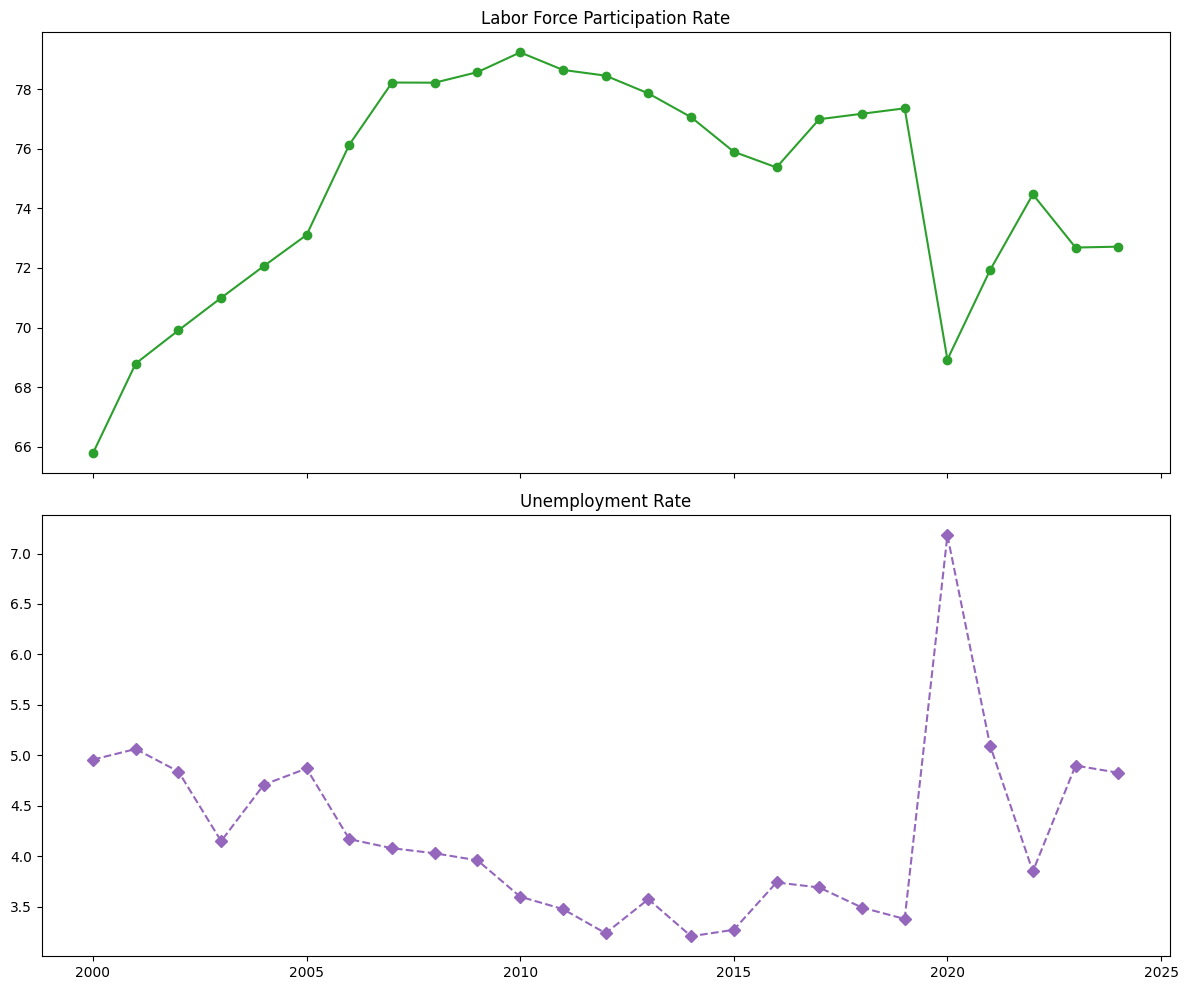

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top: Participation (Peru)
ax1.plot(
    df_per.index,
    df_per['Labor_Part_Rate'],
    color='tab:green',
    marker='o'
)
ax1.set_title('Labor Force Participation Rate')

# Bottom: Unemployment (Peru)
ax2.plot(
    df_per.index,
    df_per['Unemployment_Rate'],
    color='tab:purple',
    marker='D',
    linestyle='--'
)
ax2.set_title('Unemployment Rate')

plt.tight_layout()
plt.show()


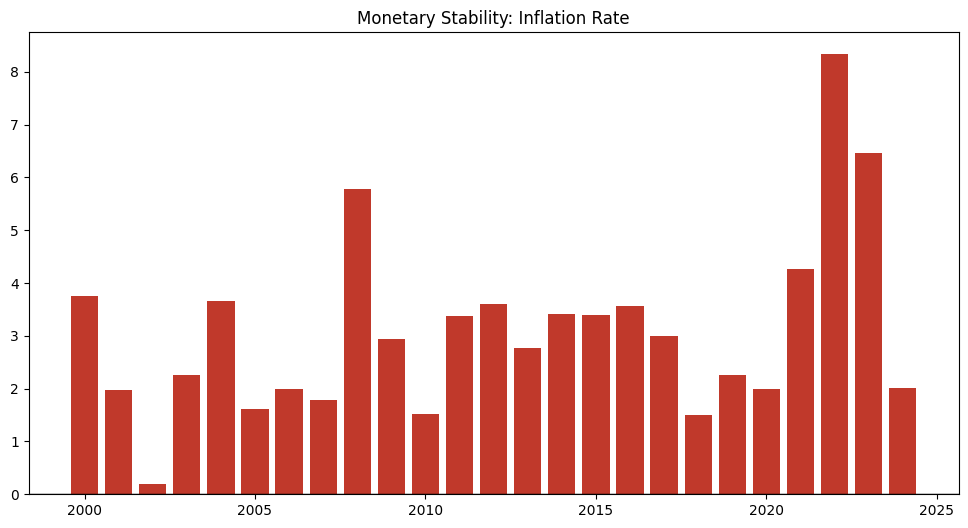

In [11]:
plt.figure(figsize=(12, 6))

plt.bar(df_per.index, df_per['Inflation_CPI'], color='#c0392b')

plt.axhline(0, color='black', linewidth=1)
plt.title('Monetary Stability: Inflation Rate')
plt.show()

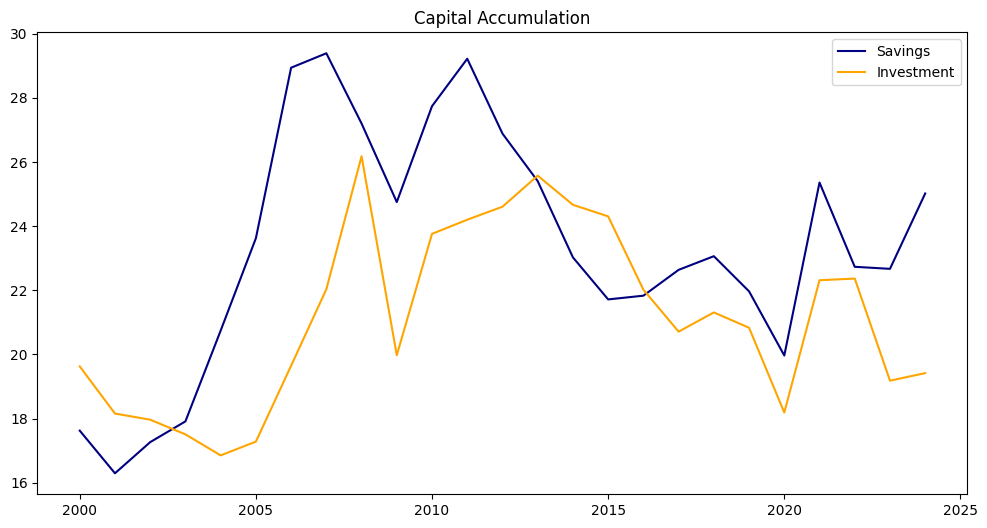

In [12]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_per.index,
    df_per['Gross_Dom_Savings'],
    label='Savings',
    color='navy'
)

plt.plot(
    df_per.index,
    df_per['Gross_Cap_Formation'],
    label='Investment',
    color='orange'
)

plt.title('Capital Accumulation')
plt.legend()
plt.show()

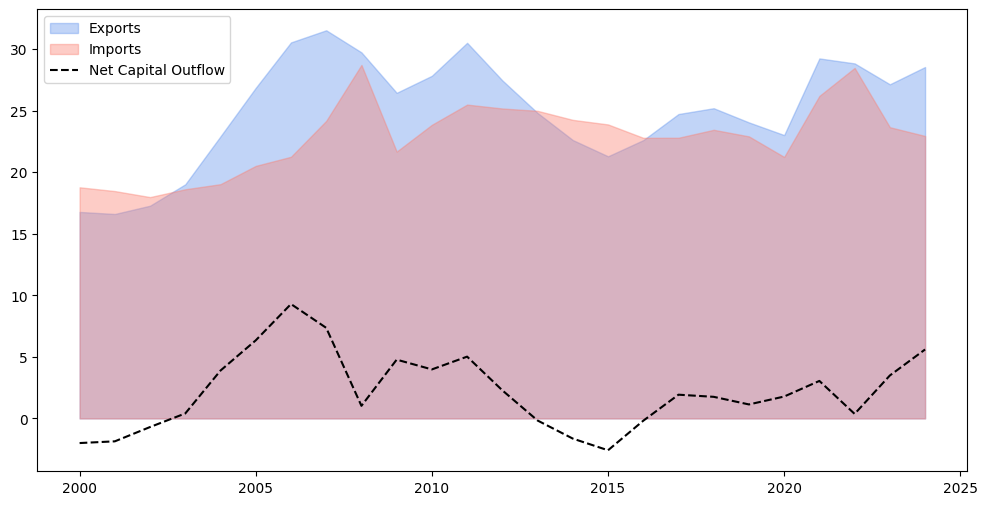

In [13]:
plt.figure(figsize=(12, 6))

plt.fill_between(
    df_per.index,
    df_per['Exports_GDP'],
    color='cornflowerblue',
    alpha=0.4,
    label='Exports'
)

plt.fill_between(
    df_per.index,
    df_per['Imports_GDP'],
    color='salmon',
    alpha=0.4,
    label='Imports'
)

plt.plot(
    df_per.index,
    df_per['NCO'],
    color='black',
    linestyle='--',
    label='Net Capital Outflow'
)

plt.legend()
plt.show()

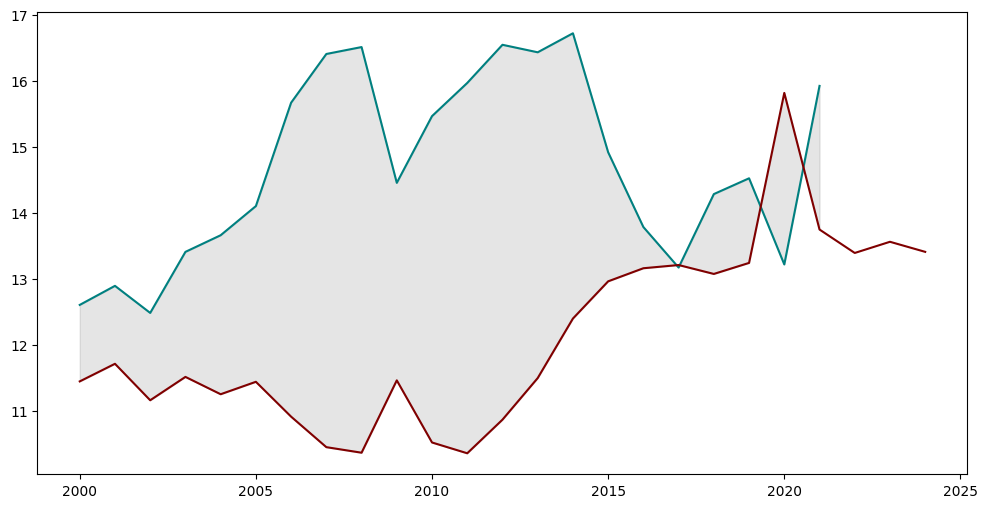

In [15]:
plt.figure(figsize=(12, 6))

plt.plot(
    df_per.index,
    df_per['Tax_Rev_GDP'],
    label='Revenue',
    color='teal'
)

plt.plot(
    df_per.index,
    df_per['Gov_Exp_GDP'],
    label='Expenditure',
    color='maroon'
)

plt.fill_between(
    df_per.index,
    df_per['Tax_Rev_GDP'],
    df_per['Gov_Exp_GDP'],
    color='gray',
    alpha=0.2
)

plt.show()

In [18]:
df.loc[2023, [('PER', 'GDP_Per_Capita_Const'),
              ('UMC', 'GDP_Per_Capita_Const')]]

,,2023
economy,series,
PER,GDP_Per_Capita_Const,6568.000278
UMC,GDP_Per_Capita_Const,9948.674954


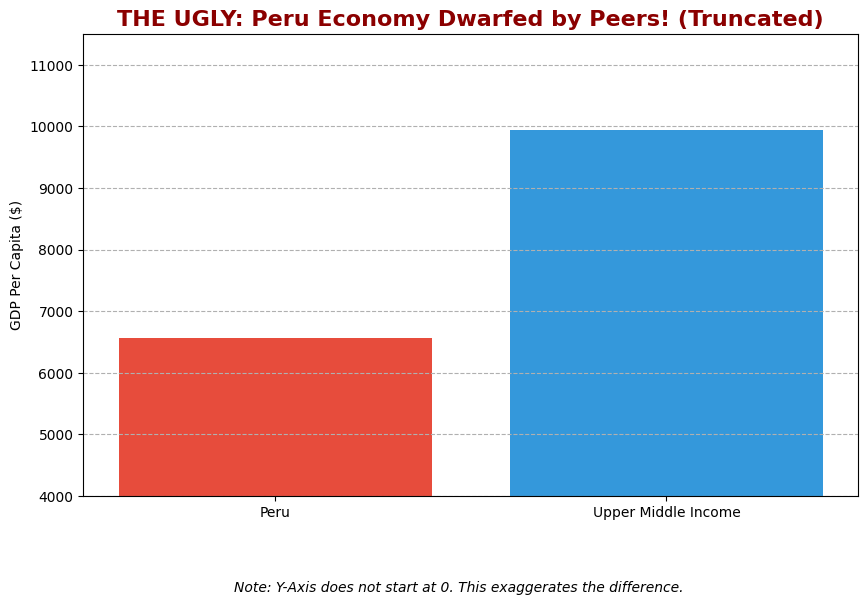

In [19]:
# THE UGLY CHART
# Setup snapshot data for the latest available year
snapshot_year = 2023
per_val = df.loc[snapshot_year, ('PER', 'GDP_Per_Capita_Const')]
umc_val = df.loc[snapshot_year, ('UMC', 'GDP_Per_Capita_Const')]

values = [per_val, umc_val]
labels = ['Peru', 'Upper Middle Income']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#e74c3c', '#3498db'])

# THE VIOLATION: Truncating the axis
# Peru is approx 6570. UMC is approx 9950.
# Starting axis above 0 exaggerates the difference.
plt.ylim(4000, 11500)

plt.title('THE UGLY: Peru Economy Dwarfed by Peers! (Truncated)',
          fontsize=16, fontweight='bold', color='darkred')
plt.ylabel('GDP Per Capita ($)')
plt.grid(axis='y', linestyle='--')
plt.figtext(0.5, -0.05,
            "Note: Y-Axis does not start at 0. This exaggerates the difference.",
            ha="center", style='italic')

plt.show()

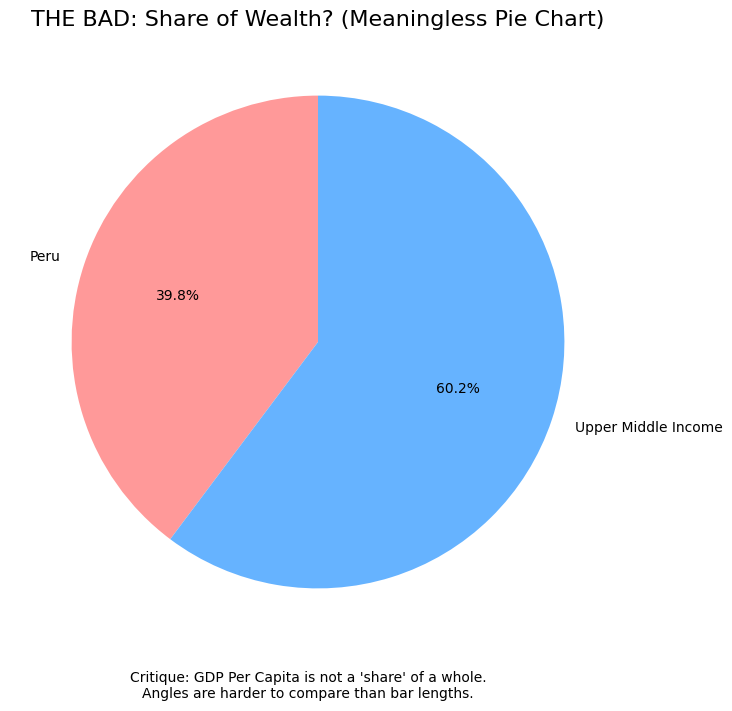

In [20]:
# CELL 9: THE BAD CHART
plt.figure(figsize=(8, 8))

# THE VIOLATION: Using a Pie Chart for non-summable data (GDP Per Capita)
# Comparison of magnitudes should be a Bar Chart, not angles.
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff'], startangle=90)

plt.title('THE BAD: Share of Wealth? (Meaningless Pie Chart)', fontsize=16)
plt.figtext(0.5, 0.05, "Critique: GDP Per Capita is not a 'share' of a whole.\nAngles are harder to compare than bar lengths.", ha="center")

plt.show()

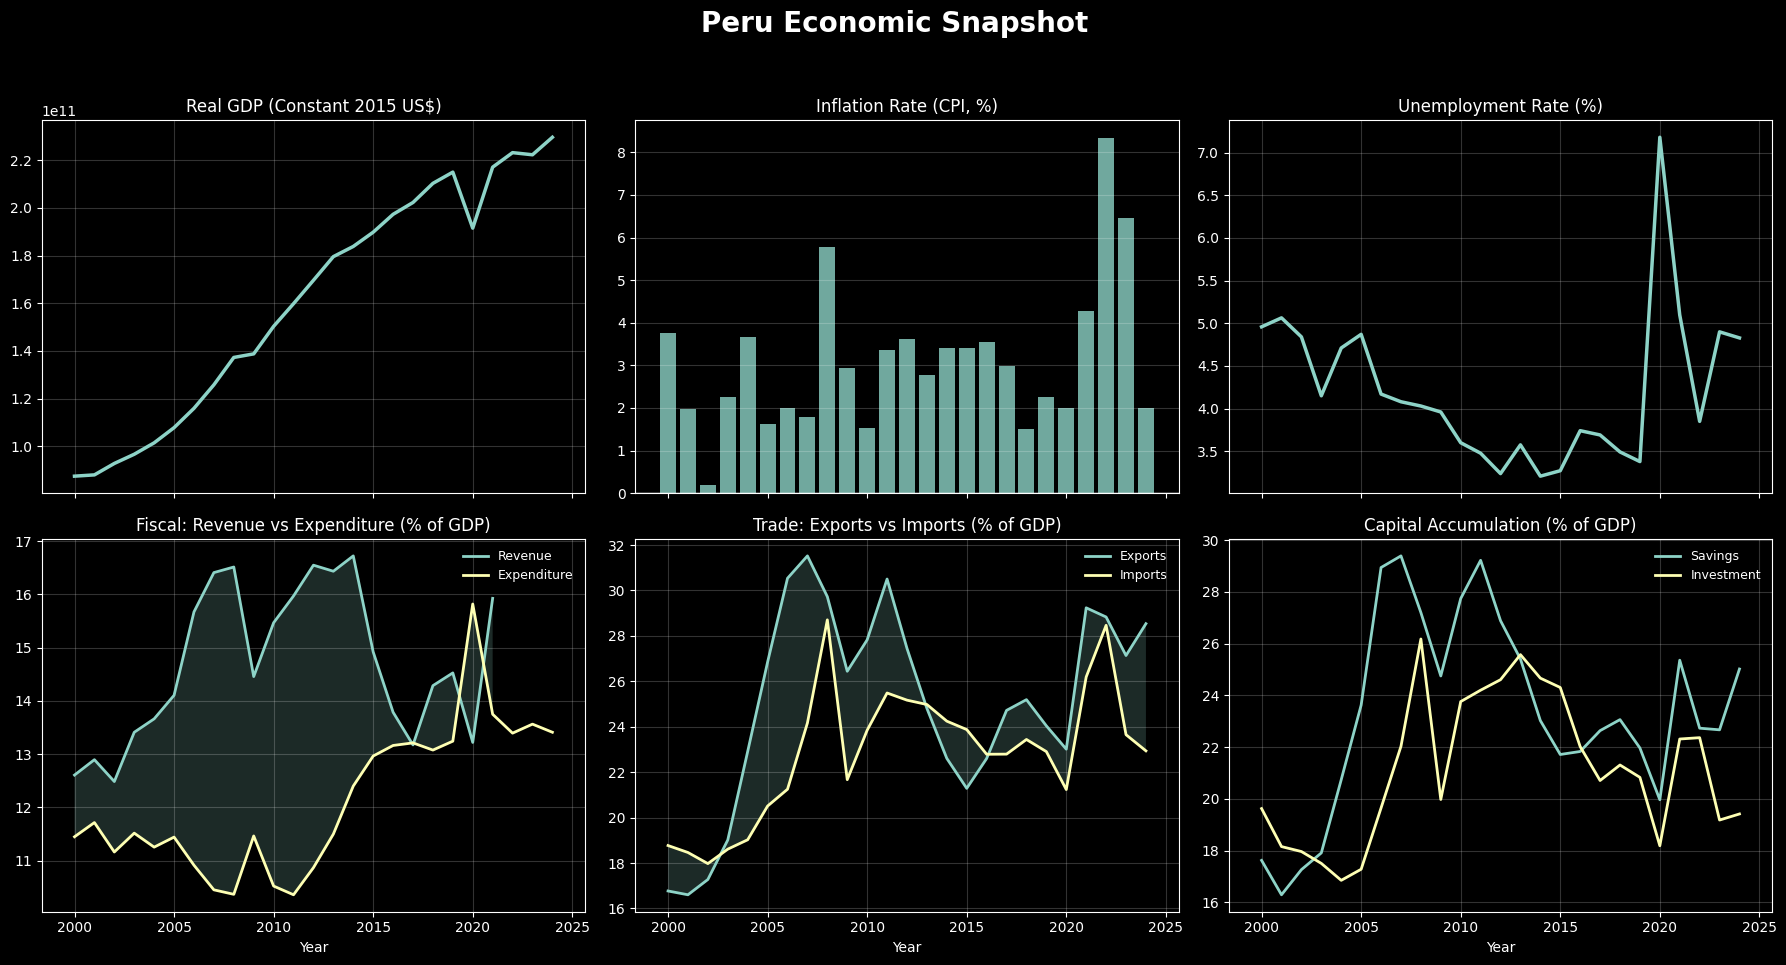

In [21]:
# Executive Dashboard (2x3) for Peru
# Assumes you already have df_per with these columns:
# GDP_Const, Inflation_CPI, Unemployment_Rate, Tax_Rev_GDP, Gov_Exp_GDP,
# Exports_GDP, Imports_GDP, Gross_Dom_Savings, Gross_Cap_Formation

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
fig.suptitle('Peru Economic Snapshot', fontsize=20, fontweight='bold')

# 1) Top Left: Real GDP (Line)
ax = axes[0, 0]
sns.lineplot(x=df_per.index, y=df_per['GDP_Const'], ax=ax, linewidth=2.5)
ax.set_title('Real GDP (Constant 2015 US$)')
ax.set_ylabel('')
ax.grid(True, alpha=0.2)

# 2) Top Middle: Inflation (Bar + 0 line)
ax = axes[0, 1]
ax.bar(df_per.index, df_per['Inflation_CPI'], alpha=0.8)
ax.axhline(0, color='white', linewidth=1)
ax.set_title('Inflation Rate (CPI, %)')
ax.set_ylabel('')
ax.grid(True, axis='y', alpha=0.2)

# 3) Top Right: Unemployment (Line)
ax = axes[0, 2]
sns.lineplot(x=df_per.index, y=df_per['Unemployment_Rate'], ax=ax, linewidth=2.5)
ax.set_title('Unemployment Rate (%)')
ax.set_ylabel('')
ax.grid(True, alpha=0.2)

# 4) Bottom Left: Fiscal Balance (Fill between revenue & spending)
ax = axes[1, 0]
ax.plot(df_per.index, df_per['Tax_Rev_GDP'], label='Revenue', linewidth=2)
ax.plot(df_per.index, df_per['Gov_Exp_GDP'], label='Expenditure', linewidth=2)
ax.fill_between(df_per.index, df_per['Tax_Rev_GDP'], df_per['Gov_Exp_GDP'], alpha=0.2)
ax.set_title('Fiscal: Revenue vs Expenditure (% of GDP)')
ax.set_ylabel('')
ax.legend(fontsize=9, frameon=False)
ax.grid(True, alpha=0.2)

# 5) Bottom Middle: Trade Balance (Fill between exports & imports)
ax = axes[1, 1]
ax.plot(df_per.index, df_per['Exports_GDP'], label='Exports', linewidth=2)
ax.plot(df_per.index, df_per['Imports_GDP'], label='Imports', linewidth=2)
ax.fill_between(df_per.index, df_per['Exports_GDP'], df_per['Imports_GDP'], alpha=0.2)
ax.set_title('Trade: Exports vs Imports (% of GDP)')
ax.set_ylabel('')
ax.legend(fontsize=9, frameon=False)
ax.grid(True, alpha=0.2)

# 6) Bottom Right: Savings vs Investment (Dual lines)
ax = axes[1, 2]
ax.plot(df_per.index, df_per['Gross_Dom_Savings'], label='Savings', linewidth=2)
ax.plot(df_per.index, df_per['Gross_Cap_Formation'], label='Investment', linewidth=2)
ax.set_title('Capital Accumulation (% of GDP)')
ax.set_ylabel('')
ax.legend(fontsize=9, frameon=False)
ax.grid(True, alpha=0.2)

# X labels
for ax in axes[1, :]:
    ax.set_xlabel('Year')
for ax in axes[0, :]:
    ax.set_xlabel('')

plt.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.show()
